# PyTorch Redes Neurais Profundas - Exemplo

## Classificador de cães e gatos

Dada uma imagem que tem um cão ou gato, vamos ser capazes de dizer qual categoria ela está.

In [1]:
import math
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np

from dataset_aula import MyDataset   # Classe que carrega dataset


In [2]:
DEVICE = 'gpu'      # 'cpu'
GPU_NUMBER = 0

PREFIX = '/media/dpetrini/KINGSTON/Daniel/nova/data_cats_dogs_old'
NUM_EPOCHS = 30
MINI_BATCH = 4
LR = 3e-4            # Learning rate - Taxa de aprendizado
PRE_TRAINED = False
NUM_WORKERS = 2

Vamos criar uma rede com duas camadas convolucionais (feature extraction) e 2 camadas lineares (classificadores).

![title](images/RedeConvolucional.png)

In [3]:
class RedeConv(nn.Module):
    """ Rede Convolucional de duas camadas """
    def __init__(self):
        super(RedeConv, self).__init__()

        self.feature_extractor = nn.Sequential(  # Rede Convolucional para extrair features
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2), 
            nn.ReLU(inplace=True),          # função de ativação não linear
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(         # Rede Neural Artificial para classificar
            nn.Linear(32*54*54, 100),
            nn.Linear(100, 2)
        )

    def forward(self, x):

        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# Funcao que executa treino e validação por diversas épocas.

def train_and_validate(model, loss_criterion, optimizer, 
                       train_data_loader, validation_data_loader, 
                       device, epochs=25, batch_size=1):

    train_data_size = len(train_data_loader) * batch_size
    val_data_size = len(validation_data_loader) * batch_size

    for epoch in range(epochs):
        epoch_start = time.time()
        print('Epoch: {}/{}'.format(epoch+1, epochs))

        model.train()       # set to training mode

        #loss and acc for the epoch
        train_loss, train_acc = 0.0, 0.0
        validation_loss, validation_acc = 0.0, 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):  # no iterator com tam=bs

            inputs = inputs.to(device)
            labels = labels.to(device)       # Aprendizagem supervisionada - ja tenho os resultados do treino

            optimizer.zero_grad()                       # clean existing gradients
            outputs = model(inputs)                     # forward pass
            loss = loss_criterion(outputs, labels)      # compute loss
            loss.backward()                             # backprop the gradients
            optimizer.step()                            # update parameters
            train_loss += loss.item() * inputs.size(0)  # compute the total loss for the batch & add

            # compute the accuracy
            acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

            # compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item()

        # validation - no gradient tracking needed
        with torch.no_grad():

            model.eval()        # set to evaluation mode

            # validation loop
            for j, (inputs, labels) in enumerate(validation_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)                         # forward pass for validation
                loss = loss_criterion(outputs, labels)	        # compute loss
                validation_loss += loss.item() * inputs.size(0) # compute the total loss for the batch & add

                # calculcate validation acc
                acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

                # compute total accuracy in the whole batch and addd to valid_acc
                validation_acc += acc.item()

        # fing average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # find average training loss and validation acc
        avg_validation_loss = validation_loss/val_data_size
        avg_validation_acc = validation_acc/val_data_size

        epoch_end = time.time()

        print('Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.2f}%, Validation: Loss: {:0.4f}, Accuracy: {:.2f}%, Time: {:.2f}s'.format(epoch+1, avg_train_loss, avg_train_acc*100, avg_validation_loss, avg_validation_acc*100, epoch_end-epoch_start))

In [5]:
def initialize(model):
    """ good init for not pre-trained """
    print("Init weights with kaiming")
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [6]:
model = RedeConv()

print(model)

RedeConv(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=93312, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [7]:
initialize(model)


if (DEVICE == "gpu") and torch.has_cudnn:
    device = torch.device("cuda:{}".format(GPU_NUMBER))
else:
    device = torch.device("cpu")

model = model.to(device)

Init weights with kaiming


In [8]:
train_image_paths = PREFIX+'/train'
val_image_paths = PREFIX+'/val'
test_image_paths = PREFIX+'/test'

# Carrega datasets
dataset_train = MyDataset(train_image_paths, train=True)
dataset_val = MyDataset(val_image_paths, train=False)
dataset_test = MyDataset(test_image_paths, train=False)

train_dataloader = DataLoader(dataset_train, batch_size=MINI_BATCH, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=MINI_BATCH, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=MINI_BATCH, shuffle=False)

print('\nSize train:', len(dataset_train), ' Size val: ', len(dataset_val))

['cats', 'dogs'] {'cats': 0, 'dogs': 1}
[Dataloader] Loaded 600, size: 90316800 bytes from /media/dpetrini/KINGSTON/Daniel/nova/data_cats_dogs_old/train
['cats', 'dogs'] {'cats': 0, 'dogs': 1}
[Dataloader] Loaded 600, size: 90316800 bytes from /media/dpetrini/KINGSTON/Daniel/nova/data_cats_dogs_old/val
['cats', 'dogs'] {'cats': 0, 'dogs': 1}
[Dataloader] Loaded 1000, size: 150528000 bytes from /media/dpetrini/KINGSTON/Daniel/nova/data_cats_dogs_old/test

Size train: 600  Size val:  600


In [9]:
#Mostrar exemplos do dataset
def show_image(im, label, ax=None, figsize=(3, 3)):
    if ax is None: _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.set_title(dataset_train.get_category(label))
    #print(im.shape, im.type())
    im = im.permute(1, 2, 0)
    ax.imshow(im)


def show_batch(x, label, c=4, r=None, figsize=None):
    n = len(x)
    cont = 0
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize = (c*3, r*3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for xi, ax in zip(x, axes.flat):
        show_image(xi, label[cont], ax)
        cont += 1
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


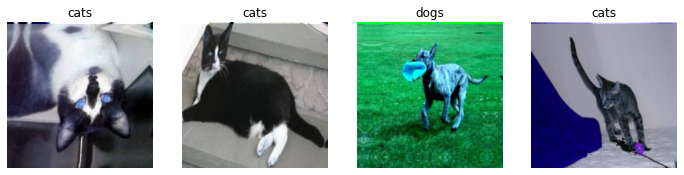

In [10]:
# show some samples
img, label = next(iter(train_dataloader))
show_batch(img[0:20], label, 4)

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [12]:
train_and_validate(model, loss_func, optimizer, train_dataloader, val_dataloader, device,
                   epochs=NUM_EPOCHS, batch_size=MINI_BATCH)

Epoch: 1/30
Epoch: 001, Training: Loss: 4.3473, Accuracy: 51.83%, Validation: Loss: 1.6183, Accuracy: 50.17%, Time: 1.95s
Epoch: 2/30
Epoch: 002, Training: Loss: 0.7710, Accuracy: 55.67%, Validation: Loss: 0.6812, Accuracy: 60.67%, Time: 1.83s
Epoch: 3/30
Epoch: 003, Training: Loss: 0.6849, Accuracy: 57.83%, Validation: Loss: 0.7070, Accuracy: 58.00%, Time: 1.96s
Epoch: 4/30
Epoch: 004, Training: Loss: 0.6907, Accuracy: 59.83%, Validation: Loss: 0.6563, Accuracy: 61.83%, Time: 2.20s
Epoch: 5/30
Epoch: 005, Training: Loss: 0.6709, Accuracy: 59.17%, Validation: Loss: 0.6503, Accuracy: 64.33%, Time: 2.06s
Epoch: 6/30
Epoch: 006, Training: Loss: 0.6461, Accuracy: 62.83%, Validation: Loss: 0.6628, Accuracy: 62.17%, Time: 1.96s
Epoch: 7/30
Epoch: 007, Training: Loss: 0.6458, Accuracy: 61.67%, Validation: Loss: 0.6351, Accuracy: 62.17%, Time: 1.86s
Epoch: 8/30
Epoch: 008, Training: Loss: 0.6556, Accuracy: 62.00%, Validation: Loss: 0.6438, Accuracy: 63.33%, Time: 1.83s
Epoch: 9/30
Epoch: 009, 

## Resultados:
    RedeConv 1: 68,5%

Como podemos melhorar esse resultado?

Vamos criar uma rede mais profunda, com uma camada convolucional a mais.

![title](images/RedeConvolucionalMaisProfunda.png)

In [19]:
class RedeConvMaisProfunda(nn.Module):
    """ Rede com uma camada convolucional a mais """
    def __init__(self):
        super(RedeConvMaisProfunda, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True)                        
            )

        self.classifier = nn.Sequential(
            nn.Linear(64*26*26, 100),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [20]:
model2 = RedeConvMaisProfunda()

print(model2)

RedeConvMaisProfunda(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=43264, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [21]:
initialize(model2)


if (DEVICE == "gpu") and torch.has_cudnn:
    device = torch.device("cuda:{}".format(GPU_NUMBER))
else:
    device = torch.device("cpu")

model2 = model2.to(device)

Init weights with kaiming


In [22]:
#loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=LR)

In [23]:
#train_and_validate(model2, loss_func, optimizer, train_dataloader, val_dataloader, device,
#                   epochs=NUM_EPOCHS, batch_size=MINI_BATCH)

Cats & Dogs Classifier

Registered Callbacks:  BaseCB  
Fix progress: train_step: 150 val_step: 150, bsize: 4, bar_step:3 bar_step_val:15

Epoch: 1/30
▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ |------>  Best Val Acc model now 0.5683
Epoch: 001, Train: Loss: 1.2167, Acc: 56.33%, Val: Loss: 0.6688, Acc: 56.83%, Time: 2.10s

Epoch: 2/30
▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ |------>  Best Val Acc model now 0.6333
Epoch: 002, Train: Loss: 0.6783, Acc: 58.17%, Val: Loss: 0.6608, Acc: 63.33%, Time: 2.03s

Epoch: 3/30
▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ |------>  Best Val Acc model now 0.6483
Epoch: 003, Train: Loss: 0.6588, Acc: 61.83%, Val: Loss: 0.6108, Acc: 64.83%, Time: 2.05s

Epoch: 4/30
▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ |------>  Best Val Acc model now 0.6517
Epoch: 004, Train: Loss: 0.6700, Acc: 63.83%, Val: Loss: 0.6206, Acc: 65.17%, Time: 2.12s

Epoch: 5/30
▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒

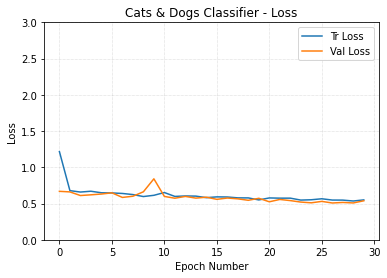

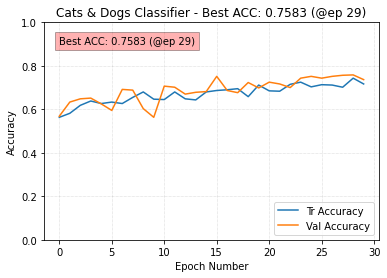


Running models in test set...
Model: normal - Test accuracy : 0.711 Test loss : 0.565
Model: best - Test accuracy : 0.715 Test loss : 0.545


<Figure size 432x288 with 0 Axes>

In [24]:
# Usando uma bibliteca com as principais funções
#
# http://www.github.com/dpetrini/nova
#
# Existe um exemplo similar com instruções para rodar completo, neste repositório

from trainer import Trainer

optim_args = {}

train_config = {
    'num_epochs': NUM_EPOCHS,
    'batch_size': MINI_BATCH,
    'name': 'aula',
    'title': 'Cats & Dogs Classifier',
    # 'features': ['auc'],
}

session = Trainer(model2, train_dataloader, val_dataloader, loss_func,
                  optimizer, optim_args, device, train_config)

# train the model
session.train_and_validate()

print("\nRunning models in test set...")
session.run_test(test_dataloader, "normal")
session.run_test(test_dataloader, "best")

## Resultados:
    RedeConv2 75,83: %